# Introduction

This notebook uses the NLTK and Scikit-learn's vectorization and logistic regression tools to train a model and use it to predict which of my emails are application-related (for clubs, internships, and jobs).

In [156]:
import time
start_time = time.time()
# Import necessary packages and silence silly warnings.
import re
import random
import itertools
import warnings
import pandas as pd 
import numpy as np
import seaborn as sns
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import DataConversionWarning
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=SettingWithCopyWarning)

In [157]:
def text_cleaner(string):
    """ This function will clean the text of email bodies by: 1. removing numbers, 
        2. keeping only words longer than 4 letters, and lemmatizing each word.
        Ensuring each word is part of the NLTK english language corpus led to exponential runtime.
    """
    split_words = re.findall("[^\d_\W]+", string)
    lemmatizer = WordNetLemmatizer() 
    split_words = [lemmatizer.lemmatize(word.lower()) for word in split_words if len(word) > 4]
    return " ".join(split_words)

def in_school_year(date):
    """Returns 1 if the date inputted is during a school month (Jan-Apr, Sept-Dec), and 0 otherwise.
    """
    month = int(re.findall(".+?(?=/)", date)[0])
    school_months = [1, 2, 3, 4, 9, 10, 11, 12]
    if month > 0 and month < 13:
        if month in school_months:
            return 1
        else:
            return 0
    else:
        return None
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Beautiful confusion matrix plotter from the Data 100 Berkeley textbook:
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    
def preprocessor(table):
    """The inputted table must have the following columns:
    "Date & Time Received": Strings formatted like "3/14/1972".
    "From": String, an email address like "me@example.com".
    "Subject": String of free-form text.
    "Email Text": String of free-form text.
    "Related": 1 if this email is internship-related, 0 if it's not.
    NOTE: The fact that the features being used are dynamically selected by this notebook based on the input
          makes it somewhat unsupervised learning."""
    # Basic pre-processing: 
    # 1. Select only relevant columns.
    table = table[["Date & Time Received", "From", "Subject", "Email Text", "Related"]].dropna().reset_index()
    # 2. Use regex to help extract the sender domain from the emails.
    table["From"] = table["From"].apply((lambda x: re.findall("(?<=@)[^.]+(?=\.)", x)[0].replace("-", " ")))
    # 3. Clean email subject and body text using function defined above. 
    table["Email Text"] = table["Email Text"].apply(text_cleaner)
    table["Subject"] = table["Subject"].apply(text_cleaner)

    # Let's do some feature engineering:
    # 1. Add a few feature that indicate 1 if the email was sent during a school month (Jan-Apr, Sept-Dec), and 0 otherwise.
    table["In School Year"] = table["Date & Time Received"].apply(in_school_year)
    # 2. Add a few feature that shows the normalized length of the email.
    table["Length"] = table["Email Text"].apply(lambda string: len(string))
    table["Length"] = StandardScaler().fit_transform(np.array(table["Length"]).reshape(-1, 1))
    # 3. Create vectorized representations of whether email is from a specific top sender.
    sv = CountVectorizer(lowercase=True, ngram_range = (1,1))
    sender_counts = sv.fit_transform(table['From'])
    sender_vectors = pd.DataFrame(sender_counts.todense(), columns=["Sender: " + i for i in sv.get_feature_names()])
    # 4. Reorder columns and rename the final column.
    table = table[["From", "Subject", "Email Text", "In School Year", "Length", "Related"]].rename(columns={"Related": "Internship-Related"})
    # 5. Add the vectors of senders to the table.
    table = pd.concat([table, sender_vectors], axis=1)
    # 6. Add the vectors of words from the email bodies to the table.
    cv_word_vectors, tv_word_vectors = cv_and_tfidf_vectorize(table)
    table = pd.concat([table, cv_word_vectors], axis=1)
    
    return table

def get_top_senders(table, count):
    """Given a table, return the top count number of email senders as a table.
    """
    sv = CountVectorizer(lowercase=True, ngram_range = (1,1))
    sender_counts = sv.fit_transform(table['From'])
    sender_vectors = pd.DataFrame(sender_counts.todense(), columns=["Sender: " + i for i in sv.get_feature_names()])
    return (sender_vectors
           .sum(axis = 0, skipna = True)
           .to_frame()
           .rename(columns={0: "Counts"})
           .sort_values(by=["Counts"], ascending=False)
           .head(count))

def cv_and_tfidf_vectorize(table):
    """ Use CountVectorizer and TfidfVectorizer to create a matrix representation of the words used across all emails, 
        ensuring that all words included are real English words as in the NLTK English Corpus.
    """    
    cv = CountVectorizer(lowercase=True, stop_words='english', ngram_range = (1,1))
    cv_word_counts = cv.fit_transform(table['Email Text'])
    cwc = pd.DataFrame(cv_word_counts.todense(), columns=cv.get_feature_names())

    tv = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range = (1,1))
    tv_word_counts = tv.fit_transform(table['Email Text'])
    tvc = pd.DataFrame(tv_word_counts.todense(), columns=tv.get_feature_names())
    
    cwc.columns.sort_values()
    tvc.columns.sort_values()
    
    real_word_list = []
    s = set(words.words())
    for i,x in enumerate(cwc.columns.sort_values()):
        if x in s:
            real_word_list.append(x)
    cwc = cwc[real_word_list]

    real_word_list = []
    for i,x in enumerate(tvc.columns.sort_values()):
        if x in s:
            real_word_list.append(x)
    tvc = tvc[real_word_list]
    
    return cwc, tvc

def vector_table_sum(table, title):
    """ Given a sparse array of vectors, returns a table with the columns summed."""
    return (table
           .sum(axis = 0, skipna = True)
           .to_frame()
           .rename(columns={0: title})
           .sort_values(by=[title], ascending=False))

def make_modeling_data(table, num_words, num_senders):
    """Use this to create a dataframe we can use for modeling."""
    top_senders = get_top_senders(table, num_senders)
    temp, word_vectors = cv_and_tfidf_vectorize(table)
    #Use a sample of the top words from the emails that are correctly tagged as features.
    #Purposely use asymptotically half from the training emails that are and aren't internship-related.
    top_related_words = list(vector_table_sum(cv_and_tfidf_vectorize(table[table["Internship-Related"] == 1])[0], "Sum of Scores").index)
    top_unrelated_words = list(vector_table_sum(cv_and_tfidf_vectorize(table[table["Internship-Related"] == 0])[0], "Sum of Scores").index)
    top_words = top_related_words + top_unrelated_words
    top_words = random.sample(top_words, int(len(top_words)/2))
    # 1. Word features (from body text):
    modeling_data = word_vectors[top_words[:num_words]] 
    # 2. Whether the email was during the school year:
    modeling_data["In School Year"] = table["In School Year"]
    # 3. Normalized length of the email's body.
    modeling_data["Length"] = table["Length"]
    # 4. Whether the email was from one of my top senders. 
    # The way .head() works means this will function even if num_senders > len(top_senders). 
    indices = [i for i in top_senders.head(num_senders).index]
    modeling_data[indices] = table[indices]
    return modeling_data

# Importing, Cleaning & Splitting Data

In [158]:
# Read in and view raw input file.
# TODO: Take away head after tagging all emails.
#6097, 9541
data = pd.read_csv("emails_as_csv_all.csv")
data

,From,To,Subject,Date & Time Received,PDF Email Body Link,Email Text,Related
0,mail-noreply@google.com,rachitpareek@berkeley.edu,"The best of Gmail, wherever you are",5/1/18,https://drive.google.com/a/berkeley.edu/file/d...,Hi Rachit\n\nGet the official Gmail app\n\nThe...,0
1,mail-noreply@google.com,rachitpareek@berkeley.edu,Tips for using your new inbox,5/1/18,https://drive.google.com/a/berkeley.edu/file/d...,Hi Rachit\n\nWelcome to your Gmail inbox\n\nSa...,0
2,calmessages@berkeley.edu,calmessages_communication@lists.berkeley.edu,Report of the Free Speech Commission,5/2/18,https://drive.google.com/a/berkeley.edu/file/d...,"Dear campus community,\n\nI am delighted to sh...",0
3,shipcomms@berkeley.edu,rachitpareek@berkeley.edu,Fall 2018 SHIP Benefits and Waiver Info,5/3/18,https://drive.google.com/a/berkeley.edu/file/d...,"As a non-academic condition of enrollment, you...",0
4,orres@berkeley.edu,rachitpareek@berkeley.edu,California Residence for Tuition Purposes,5/3/18,https://drive.google.com/a/berkeley.edu/file/d...,"May 3, 2018\nRE: California R...",0
...,...,...,...,...,...,...,...
9645,admin@empowerly.com,rachitpareek@berkeley.edu,New Essay to Edit,12/25/19,https://drive.google.com/a/berkeley.edu/file/d...,"Hi Rachit,\n\nA new essay needs review. Click ...",0
9646,admin@empowerly.com,rachitpareek@berkeley.edu,New Essay to Edit,12/25/19,https://drive.google.com/a/berkeley.edu/file/d...,"Hi Rachit,\n\nA new essay needs review. Click ...",0
9647,admin@empowerly.com,rachitpareek@berkeley.edu,New Essay to Edit,12/25/19,https://drive.google.com/a/berkeley.edu/file/d...,"Hi Rachit,\n\nA new essay needs review. Click ...",0
9648,admin@empowerly.com,rachitpareek@berkeley.edu,New Essay to Edit,12/25/19,https://drive.google.com/a/berkeley.edu/file/d...,"Hi Rachit,\n\nA new essay needs review. Click ...",0


In [159]:
#Run preprocessor on data table. See function definition for description.
data = preprocessor(data)

#Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(data.drop(["Internship-Related"], axis=1),
                                                    data["Internship-Related"].to_frame(),
                                                    test_size=0.2)
training_data = pd.concat([X_train, y_train], axis=1).sort_index().reset_index()
testing_data = pd.concat([X_test, y_test], axis=1).sort_index().reset_index()

print(str(round(training_data["Internship-Related"].sum()*100/len(training_data), 2)) + "% of the training emails are internship-related.")
print(f'Training set size: {len(training_data)} emails')
print(f'Test set size: {len(testing_data)} emails')

29.79% of the training emails are internship-related.
Training set size: 7708 emails
Test set size: 1928 emails


# Exploratory Data Analysis

In [160]:
# Let's try and find out which words are the most important.
cv_word_vectors, tv_word_vectors = cv_and_tfidf_vectorize(training_data[training_data["Internship-Related"] == 0])

In [161]:
cv_word_vectors.head(5)

,aardvark,abandon,abandoned,abandonment,abbreviation,abdal,aberrant,abhor,abide,abiding,...,zenith,zero,zesty,zimbabwe,zipper,zipping,zone,zoning,zoology,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [162]:
tv_word_vectors.head(5)

,aardvark,abandon,abandoned,abandonment,abbreviation,abdal,aberrant,abhor,abide,abiding,...,zenith,zero,zesty,zimbabwe,zipper,zipping,zone,zoning,zoology,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


These are the most common words from the training emails that aren't truly internship-related.


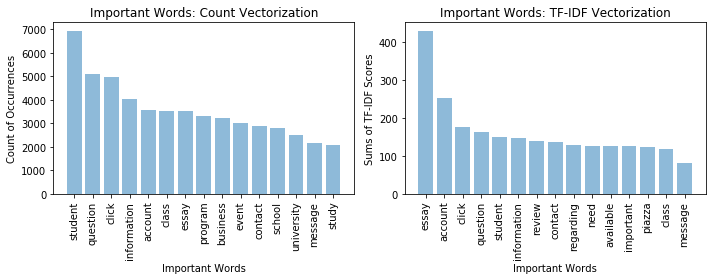

In [163]:
# Because the matrices are sparse, we can't interpret much from them. Let's visualize which words are the most 
# common & have the most importance under both vectorization schemes:
cv_sums = vector_table_sum(cv_word_vectors, "Sum of Counts")
tv_sums = vector_table_sum(tv_word_vectors, "Sum of Scores")

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.bar(np.arange(len(cv_sums.head(15))), np.array(cv_sums.head(15)["Sum of Counts"]), align='center', alpha=0.5)
plt.xticks(np.arange(len(cv_sums.head(15))), np.array(cv_sums.head(15).index), rotation='vertical')
plt.xlabel('Important Words')
plt.ylabel('Count of Occurrences')
plt.title('Important Words: Count Vectorization')

plt.subplot(122)
plt.bar(np.arange(len(tv_sums.head(15))), np.array(tv_sums.head(15)["Sum of Scores"]), align='center', alpha=0.5)
plt.xticks(np.arange(len(tv_sums.head(15))), np.array(tv_sums.head(15).index), rotation='vertical')
plt.xlabel('Important Words')
plt.ylabel('Sums of TF-IDF Scores')
plt.title('Important Words: TF-IDF Vectorization')

plt.tight_layout();
print("These are the most common words from the training emails that aren't truly internship-related.")

These are the most common words from the training emails that are truly internship-related.


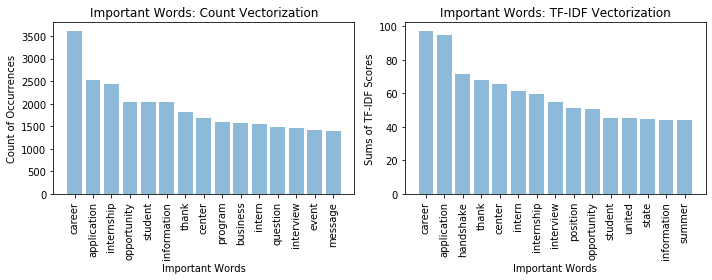

In [164]:
cv_word_vectors, tv_word_vectors = cv_and_tfidf_vectorize(training_data[training_data["Internship-Related"] == 1])

# Because the matrices are sparse, we can't interpret much from them. Let's visualize which words are the most 
# common & have the most importance under both vectorization schemes:
cv_sums = vector_table_sum(cv_word_vectors, "Sum of Counts")
tv_sums = vector_table_sum(tv_word_vectors, "Sum of Scores")

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.bar(np.arange(len(cv_sums.head(15))), np.array(cv_sums.head(15)["Sum of Counts"]), align='center', alpha=0.5)
plt.xticks(np.arange(len(cv_sums.head(15))), np.array(cv_sums.head(15).index), rotation='vertical')
plt.xlabel('Important Words')
plt.ylabel('Count of Occurrences')
plt.title('Important Words: Count Vectorization')

plt.subplot(122)
plt.bar(np.arange(len(tv_sums.head(15))), np.array(tv_sums.head(15)["Sum of Scores"]), align='center', alpha=0.5)
plt.xticks(np.arange(len(tv_sums.head(15))), np.array(tv_sums.head(15).index), rotation='vertical')
plt.xlabel('Important Words')
plt.ylabel('Sums of TF-IDF Scores')
plt.title('Important Words: TF-IDF Vectorization')

plt.tight_layout();
print("These are the most common words from the training emails that are truly internship-related.")

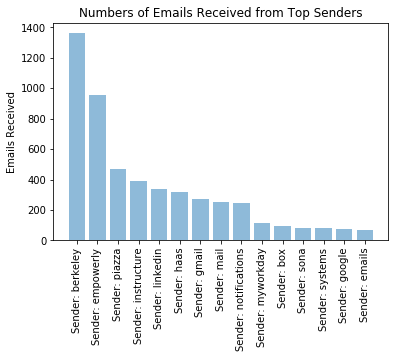

In [165]:
top_senders = get_top_senders(training_data, 15)

plt.bar(np.arange(len(top_senders)), np.array(top_senders["Counts"]), align='center', alpha=0.5)
plt.xticks(np.arange(len(top_senders)), np.array(top_senders.index), rotation='vertical')
plt.ylabel('Emails Received')
plt.title('Numbers of Emails Received from Top Senders')
plt.show()

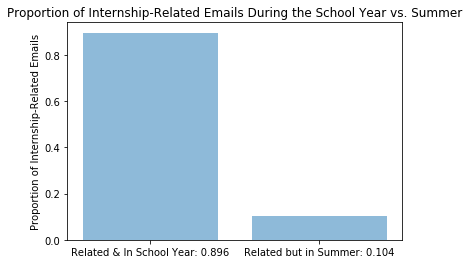

In [166]:
# This visualization seems to show that there's a strong connection between whether the email was sent during a school
# month and whether it was an internship-related email. The grind really concentrates itself in school months, and
# it would be odd, after all, to already be searching for another internship while working another one during the summer!
both = len(training_data[(training_data["In School Year"] > 0) & (training_data["Internship-Related"] > 0)])/len(training_data[(training_data["Internship-Related"] > 0)])
summer_internship = len(training_data[(training_data["In School Year"] == 0) & (training_data["Internship-Related"] > 0)])/len(training_data[(training_data["Internship-Related"] > 0)])
plt.bar(np.arange(2), [both, summer_internship], align='center', alpha=0.5)
plt.xticks(np.arange(2), 
           [f'Related & In School Year: {round(both, 3)}', f'Related but in Summer: {round(summer_internship, 3)}'])
plt.ylabel('Proportion of Internship-Related Emails')
plt.title('Proportion of Internship-Related Emails During the School Year vs. Summer')
plt.show()

# Fitting the Model

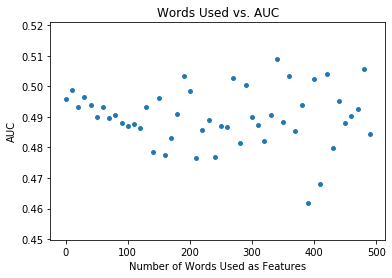

In [167]:
# Let's try finding out what the best number of words to use as features is.
results = []
#percent_done = 0
for num in range(0, 500, 10):
    
    #percent_done += 100/((200-0)/20)
    
    word_num = num
    senders = 0

    X_train = make_modeling_data(training_data, word_num, senders)
    X_test = make_modeling_data(testing_data, word_num, senders)

    logistic_model = LogisticRegression(max_iter=5000)
    logistic_model.fit(X_train, training_data["Internship-Related"])

    score = logistic_model.score(X_test, testing_data["Internship-Related"])
    coefs = logistic_model.coef_
    logistic_model_probabilities = logistic_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, logistic_model_probabilities)
    results.append((word_num, score, auc))
    #print(percent_done, "% done")

word_nums, aucs = [i[0] for i in results], [i[2] for i in results]
best_word_num = word_nums[aucs.index(max(aucs))]
plt.scatter(word_nums, aucs, s=15)
plt.title('Words Used vs. AUC')
plt.xlabel('Number of Words Used as Features')
plt.ylabel('AUC');

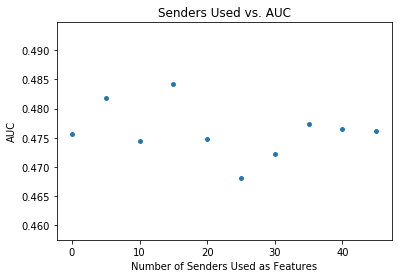

In [168]:
# Now, given that the best number of words to use seems to be around 75 (although higher seems better, overfitting
# seems to be causing a lot of variance), let's try finding out what the best number of senders to use as features is.
results = []
#percent_done = 0
for num in range(0, 50, 5):
    
    #percent_done += 100/((50-0)/5)
    
    word_num = best_word_num
    senders = num

    X_train = make_modeling_data(training_data, word_num, senders)
    X_test = make_modeling_data(testing_data, word_num, senders)

    logistic_model = LogisticRegression(max_iter=5000)
    logistic_model.fit(X_train, training_data["Internship-Related"])

    score = logistic_model.score(X_test, testing_data["Internship-Related"])
    coefs = logistic_model.coef_
    logistic_model_probabilities = logistic_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, logistic_model_probabilities)
    results.append((senders, score, auc))
    #print(percent_done, "% done")

sender_nums, aucs = [i[0] for i in results], [i[2] for i in results]
best_senders_num = sender_nums[aucs.index(max(aucs))]
plt.scatter(sender_nums, aucs, s=15)
plt.title('Senders Used vs. AUC')
plt.xlabel('Number of Senders Used as Features')
plt.ylabel('AUC');

In [169]:
# Here, I use the number of words and senders that lead to the highest AUCs above.
X_train = make_modeling_data(training_data, best_word_num, best_senders_num)
X_test = make_modeling_data(testing_data, best_word_num, best_senders_num)

#Now, let's fit our model.
logistic_model = LogisticRegression(max_iter=5000)
logistic_model.fit(X_train, training_data["Internship-Related"])

score = logistic_model.score(X_test, testing_data["Internship-Related"])
precision = precision_score(y_test, logistic_model.predict(X_test))
recall = recall_score(y_test, logistic_model.predict(X_test))
logistic_model_probabilities = logistic_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, logistic_model_probabilities)
print(f'Number of features: {len(X_train.columns)}')

Number of features: 357


# Analyzing the Model's Performance

In [170]:
print(f'Score: {score}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'AUC: {auc}')

Score: 0.7474066390041494
Precision: 0.2819767441860465
Recall: 0.33856893542757416
AUC: 0.4828590380144639


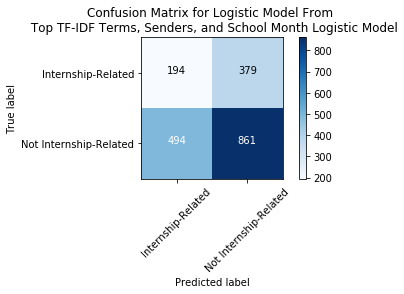

In [171]:
# Let's use a confusion matrix to analyze the performance of the classifier.
class_names = ["Internship-Related", "Not Internship-Related"]
conf_mat = confusion_matrix(y_test, logistic_model.predict(X_test), labels=[1, 0])
plot_confusion_matrix(conf_mat, classes=class_names, title='Confusion Matrix for Logistic Model From '
                      + '\n Top TF-IDF Terms, Senders, and School Month Logistic Model')

AUC: 0.4828590380144639


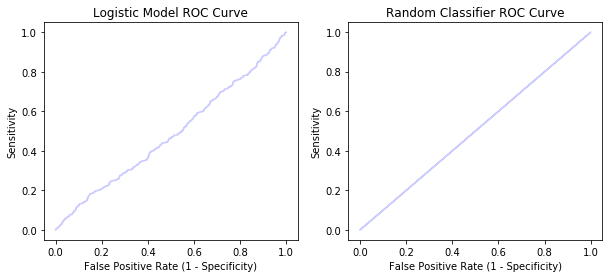

In [172]:
# Let's use an ROC curve to more visually understand the performance of the classifier compared to a random one.
logistic_model_probabilities = logistic_model.predict_proba(X_test)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_test, logistic_model_probabilities, pos_label=1)

auc = roc_auc_score(y_test, logistic_model_probabilities)
print(f'AUC: {auc}')

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.step(false_positive_rate_values, sensitivity_values, color='b', alpha=0.2,
         where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')
plt.title('Logistic Model ROC Curve')

plt.subplot(122)
plt.step(np.arange(0, 1, 0.001), np.arange(0, 1, 0.001), color='b', alpha=0.2,
         where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')
plt.title('Random Classifier ROC Curve')
plt.show();

In [173]:
# Rows where my model's predictions are wrong:
testing_data["Predicted Value"] = logistic_model.predict(X_test)
testing_data[testing_data["Internship-Related"] != testing_data["Predicted Value"]][["From", "Subject", "Email Text", "Internship-Related", "Predicted Value"]]

,From,Subject,Email Text,Internship-Related,Predicted Value
101,gmail,opportunity write undergrad,student wonderful first semester bombarded ema...,1,0
108,ijet,alert protest worcester,worldcue alert severity warning alert security...,0,1
110,heartfield,undeliverable shoreditch journal,delivery failed these recipient group james he...,0,1
112,ijet,alert measles birmingham england,worldcue alert severity warning alert health e...,0,1
114,emails,advisory message welcome nixle community alert...,message nixle nixle unsubscribe tuesday septem...,0,1
...,...,...,...,...,...
1892,go,thank joining facebook developer,rachit welcome facebook developer joined creat...,0,1
1894,successfactors,thank,december rachit thank interest project managem...,0,1
1897,ucsf,office hour protect patentable thurs mission,email browser leading expert network available...,0,1
1910,everbridge,ucbwarnme avoid crescent,update clear police activity receiving future ...,0,1


In [174]:
print("--- %s minutes ---" % round((time.time() - start_time)/60, 3))

--- 16.242 minutes ---


# Future Improvments:
- Vectorize the email subject as well.
- Segment training data into a validation set and use cross-validation.